In [9]:
# todo: minimize imports
from transformers import BigBirdPegasusForConditionalGeneration, AutoTokenizer, AutoModelForSeq2SeqLM
import sys
import json
import pickle
from rouge_score import rouge_scorer
from rouge_score import scoring
import pandas as pd
from transformers import AutoTokenizer
from lexrank import STOPWORDS, LexRank
import matplotlib.pyplot as plt
import numpy as np

In [10]:
class ResearchArticle(object):
    def __init__(self, article_id, abstract_text, article_text):
        """
          'article_id': str,
          'abstract_text': List[str],
          'article_text': List[str],
        """
        self.article_id = article_id
        self.abstract_text = abstract_text
        self.article_text = article_text


def load_data(path):
    """
    path - path where data is stored

    data - returns data as ResearchArticle objects

    """
    with open(path, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

def shuffle_and_sample(data):
    random.seed(42)
    random.shuffle(data)
    return data[:600]


def to_paragraph(text):
    """
    converts text comprised of lists of sentances to a single to_paragraph

    text - list of multiple string sentances

    continuous_text - single continuous text string
    """
    continuous_text = ''
    for line in text:
        continuous_text += line
    return continuous_text

def get_scores(hypothesis, reference):
    """
    if hypothesis and or reference is converted to summary or not, this returns
    the rouge score of the two

    hypothesis - list of sentances or single paragraph

    reference - list of sentances or single paragraph

    score - rouge scores Todo:specify output
    """
    if len(hypothesis) !=1:
        hypothesis_abstract = to_paragraph(hypothesis)
    if len(reference) != 1:
        reference_abstract = to_paragraph(reference)
    rouge = Rouge()
    score = rouge.get_scores(hypothesis_abstract, reference_abstract)
    return score

In [6]:
# import data
# todo: convert to proper location
mini_val = pd.read_csv('../data/ranked_data/ranked_mini_val_df.csv')
mini_val.head()

,text,target
0,thus not only is the 8-item qvsfs a useful too...,<S> backgroundthe questionnaire for verifying ...
1,active tobacco smoking was associated with a h...,<S> backgroundthe harmful effects of medicatio...
2,the aim of the present study was to compare th...,<S> background : nickel - titanium ( ni - ti )...
3,crossmodal matches between distinct sensory di...,<S> are chimpanzees synaesthetic ? an affirm...
4,there are no reports specifically about em cau...,<S> we report a case of a 34-year - old woman ...


In [ ]:
summaries_df = pd.DataFrame(columns=['reference', 'prediction'])
results = {}
# initialize tokenizer, model, and scorer
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-pubmed")
model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-pubmed")
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeLsum"], use_stemmer=True)
aggregator = scoring.BootstrapAggregator()
for i in range(len(mini_val)):
    document = mini_val.text[i]
    summary = mini_val.target[i]
    input = tokenizer(document, return_tensors='pt', max_length=4096, truncation=True)
    prediction = model.generate(**input)
    prediction = tokenizer.batch_decode(prediction)
    score = scorer.score(summary, prediction[0])
    aggregator.add_scores(score)
    ag_score = aggregator.aggregate()
    results[i] = score
    addition = pd.DataFrame([[to_paragraph(summary), prediction[0]]],columns=['reference', 'prediction'])
    summaries_df = summaries_df.append(addition, ignore_index=True)
    if i % 10 == 0:
        print(f'Processed {i} documents')
final_ag_score = ag_score
print('Completed document evaluation')
print(final_ag_score)
with open("lexrank_ranked_results.txt", 'w') as outfile:
    json.dump(results, outfile)
summaries_df.to_csv('lexrank_ranked_bigbird_summaries.csv', index=False)

Processed 0 documents
Processed 10 documents
Processed 20 documents
Processed 30 documents
Processed 40 documents
Processed 50 documents
Processed 60 documents
Processed 70 documents
Processed 80 documents
Processed 90 documents
Processed 100 documents
Processed 110 documents
Processed 120 documents
Processed 130 documents
Processed 140 documents
Processed 150 documents
Processed 160 documents
Processed 170 documents


Attention type 'block_sparse' is not possible if sequence_length: 457 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Processed 180 documents
Processed 190 documents
Processed 200 documents
Processed 210 documents
Processed 220 documents
Processed 230 documents
Processed 240 documents
Processed 250 documents
Processed 260 documents
Processed 270 documents
Processed 280 documents
Processed 290 documents
Processed 300 documents
Processed 310 documents
Processed 320 documents
Processed 330 documents
Processed 340 documents
Processed 350 documents
Processed 360 documents
Processed 370 documents
Processed 380 documents
Processed 390 documents
Processed 400 documents
Processed 410 documents


# Analysis

In [18]:
!ls data

create_mini_val_lexrank_csv.ipynb  mini_val_indexes.txt   ranked_data
doc_results.txt			   mini_val_set_json.txt  ranked_temporal_data
json_train.txt			   oldbindata		  raw_data


In [16]:
# gedata/rate token lenghts for each document
# read in validation data
with open('../data/mini_val_set_json.txt') as json_file:
    mini_val = json.load(json_file)
mini_val = mini_val['data']
# test to evaluate if these are the correct indexes (should print 600)
# read indexes
with open('../data/mini_val_indexes.txt') as f:
    indexes = set(f.read().split('\t'))
# compare indexes
correct = 0
for i in mini_val:
    if i['article_id'] in indexes:
        correct += 1
print(f'{correct} correct indexes.')
token_lengths = {}
#instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-pubmed")
for i in mini_val:
    token_lengths[i['article_id']] = len(tokenizer(i['article_text'],is_split_into_words=True, return_tensors='pt', truncation=False)[0])

600 correct indexes.


Token indices sequence length is longer than the specified maximum sequence length for this model (6506 > 4096). Running this sequence through the model will result in indexing errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/jupyter/Test/longsum0/experiment_notebooks


In [1]:
with open('../results/temporal_trucated_doc_results.txt') as json_file:
    results = json.load(json_file)
    
df = pd.DataFrame.from_dict(results, orient='index') # import data into pandas

# UDFs to unpack values
def unpack_f1(line, index=2):
    return line[index]
def unpack_precision(line, index=0):
    return line[index]
def unpack_recall(line, index=1):
    return line[index]
# UDF to get length
def get_length(article_id, token_lengths=token_lengths):
    return token_lengths[article_id]


# unpack values into individual columns
df['rouge_1_f1'] = df.rouge1.apply(unpack_f1)
df['rouge_1_recall'] = df.rouge1.apply(unpack_recall)
df['rouge_1_precision'] = df.rouge1.apply(unpack_precision)
df['rouge_2_f1'] = df.rouge2.apply(unpack_f1)
df['rouge_2_recall'] = df.rouge2.apply(unpack_recall)
df['rouge_2_precision'] = df.rouge2.apply(unpack_precision)
df['rouge_lsum_f1'] = df.rougeLsum.apply(unpack_f1)
df['rouge_lsum_recall'] = df.rougeLsum.apply(unpack_recall)
df['rouge_lsum_precision'] = df.rougeLsum.apply(unpack_precision)

# reset index and rename article id field
df.reset_index(inplace=True)
df.rename({'index':'article_id'},axis=1, inplace=True)
df.article_id = [i['article_id'] for i in mini_val]
# add length
df['length'] = df.article_id.apply(get_length)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../results/temporal_trucated_doc_results.txt'

m1: 5.297789481275836e-08, m2: -3.062645580154e-06, m3: -2.048736021728973e-06
m4: -8.889209391761585e-07, m5: -1.6756839013304539e-06, m6: -1.4532378729633772e-06
m7: 1.1615221990991664e-06, m8: -1.2933144642766474e-06, m9: -4.7537813499633385e-07


Rouge 1 f1 Mean: 0.41272501248082616
Rouge 2 f1 Mean: 0.15140309214312156
Rouge lsum f1 Mean: 0.24762830061279653


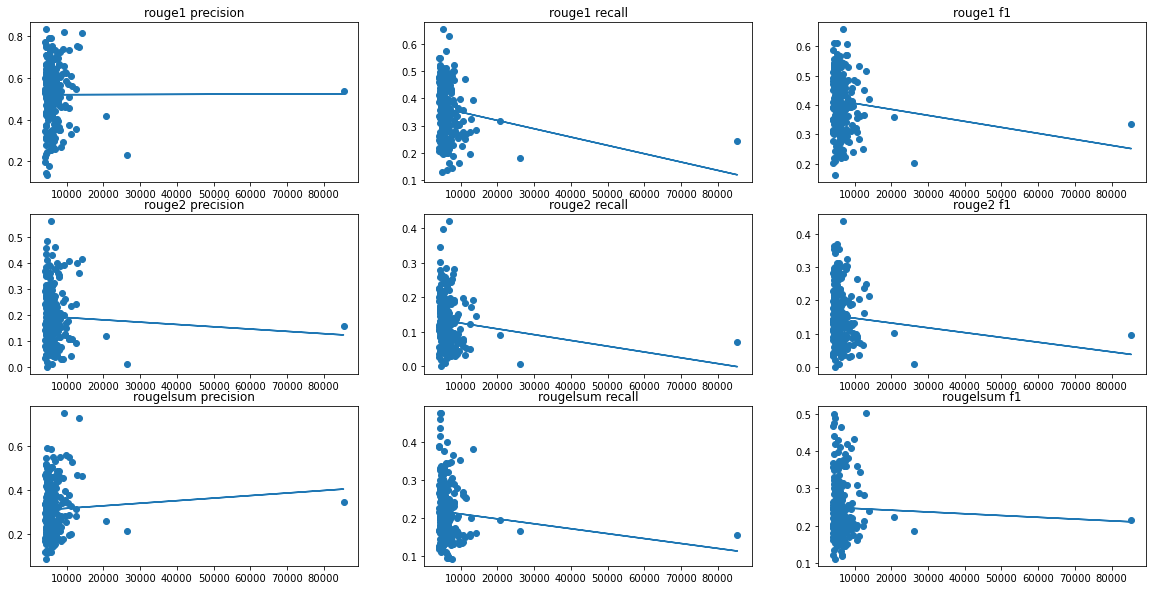

In [33]:
#df = df[df['length'] >= 4096]
fig, axs = plt.subplots(3,3, figsize = (20,10))
axs[0,0].set_title('rouge1 precision')
axs[0,0].scatter(df.length, df.rouge_1_precision)
m1, b1 = np.polyfit(df.length, df.rouge_1_precision, 1)
axs[0,0].plot(df.length, m1*df.length + b1)
#rouge 1
axs[0,1].set_title('rouge1 recall')
axs[0,1].scatter(df.length, df.rouge_1_recall)
m2, b2 = np.polyfit(df.length, df.rouge_1_recall, 1)
axs[0,1].plot(df.length, m2*df.length + b2)

axs[0,2].set_title('rouge1 f1')
axs[0,2].scatter(df.length, df.rouge_1_f1)
m3, b3 = np.polyfit(df.length, df.rouge_1_f1, 1)
axs[0,2].plot(df.length, m3*df.length + b3)


# rouge 2
axs[1,0].set_title('rouge2 precision')
axs[1,0].scatter(df.length, df.rouge_2_precision)
m4, b4 = np.polyfit(df.length, df.rouge_2_precision, 1)
axs[1,0].plot(df.length, m4*df.length + b4)

axs[1,1].set_title('rouge2 recall')
axs[1,1].scatter(df.length, df.rouge_2_recall)
m5, b5 = np.polyfit(df.length, df.rouge_2_recall, 1)
axs[1,1].plot(df.length, m5*df.length + b5)

axs[1,2].set_title('rouge2 f1')
axs[1,2].scatter(df.length, df.rouge_2_f1)
m6, b6 = np.polyfit(df.length, df.rouge_2_f1, 1)
axs[1,2].plot(df.length, m6*df.length + b6)


# rouge lsum
axs[2,0].set_title('rougelsum precision')
axs[2,0].scatter(df.length, df.rouge_lsum_precision)
m7, b7 = np.polyfit(df.length, df.rouge_lsum_precision, 1)
axs[2,0].plot(df.length, m7*df.length + b7)

axs[2,1].set_title('rougelsum recall')
axs[2,1].scatter(df.length, df.rouge_lsum_recall)
m8, b8 = np.polyfit(df.length, df.rouge_lsum_recall, 1)
axs[2,1].plot(df.length, m8*df.length + b8)

axs[2,2].set_title('rougelsum f1')
axs[2,2].scatter(df.length, df.rouge_lsum_f1)
m9, b9 = np.polyfit(df.length, df.rouge_lsum_f1, 1)
axs[2,2].plot(df.length, m9*df.length + b9)

print(f'm1: {m1}, m2: {m2}, m3: {m3}')
print(f'm4: {m4}, m5: {m5}, m6: {m6}')
print(f'm7: {m7}, m8: {m8}, m9: {m9}')
print('\n')
print(f'Rouge 1 f1 Mean: {df.rouge_1_f1.mean()}')
print(f'Rouge 2 f1 Mean: {df.rouge_2_f1.mean()}')
print(f'Rouge lsum f1 Mean: {df.rouge_lsum_f1.mean()}')

# temporal alingment

In [18]:
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
bigbird_baseline_test.ipynb  lexrank_bigbird_test.ipynb  lexrank_test.ipynb


In [7]:
mini_val = pd.read_csv('../data/ranked_temporal_data/ranked_mini_val_df.csv')

In [3]:
# import data
mini_val = pd.read_csv('../data/ranked_temporal_data/ranked_temporal_mini_val_df.csv')
mini_val.head()

,text,target
0,there is an epidemic of stroke in low and midd...,<S> backgroundthe questionnaire for verifying ...
1,"effectively , maternal smoking during pregnanc...",<S> backgroundthe harmful effects of medicatio...
2,stainless steel and nickel - titanium ( ni - t...,<S> background : nickel - titanium ( ni - ti )...
3,"ludwig , adachi , and matzuzawa ( 2011 ) recen...",<S> are chimpanzees synaesthetic ? an affirm...
4,erythema multiforme ( em ) is an acute self - ...,<S> we report a case of a 34-year - old woman ...


In [ ]:
summaries_df = pd.DataFrame(columns=['reference', 'prediction'])
results = {}
# initialize tokenizer, model, and scorer
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-pubmed")
model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-pubmed")
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeLsum"], use_stemmer=True)
aggregator = scoring.BootstrapAggregator()
for i in range(len(mini_val)):
    document = mini_val.text[i]
    summary = mini_val.target[i]
    input = tokenizer(document, return_tensors='pt', max_length=4096, truncation=True)
    prediction = model.generate(**input)
    prediction = tokenizer.batch_decode(prediction)
    score = scorer.score(summary, prediction[0])
    aggregator.add_scores(score)
    ag_score = aggregator.aggregate()
    results[i] = score
    addition = pd.DataFrame([[to_paragraph(summary), prediction[0]]],columns=['reference', 'prediction'])
    summaries_df = summaries_df.append(addition, ignore_index=True)
    if i % 10 == 0:
        print(f'Processed {i} documents')
final_ag_score = ag_score
print('Completed document evaluation')
print(final_ag_score)
with open("temporal_trucated_doc_results.txt", 'w') as outfile:
    json.dump(results, outfile)
summaries_df.to_csv('bigbird_baseline_summaries.csv', index=False)


Processed 0 documents
Processed 10 documents
Processed 20 documents
Processed 30 documents


In [18]:
with open('../results/temporal_trucated_doc_results.txt') as json_file:
    results = json.load(json_file)

with open('../data/mini_val_set_json.txt') as json_file:
    mini_val = json.load(json_file)
mini_val = mini_val['data']

df = pd.DataFrame.from_dict(results, orient='index') # import data into pandas

# UDFs to unpack values
def unpack_f1(line, index=2):
    return line[index]
def unpack_precision(line, index=0):
    return line[index]
def unpack_recall(line, index=1):
    return line[index]
# UDF to get length
def get_length(article_id, token_lengths=token_lengths):
    return token_lengths[article_id]


# unpack values into individual columns
df['rouge_1_f1'] = df.rouge1.apply(unpack_f1)
df['rouge_1_recall'] = df.rouge1.apply(unpack_recall)
df['rouge_1_precision'] = df.rouge1.apply(unpack_precision)
df['rouge_2_f1'] = df.rouge2.apply(unpack_f1)
df['rouge_2_recall'] = df.rouge2.apply(unpack_recall)
df['rouge_2_precision'] = df.rouge2.apply(unpack_precision)
df['rouge_lsum_f1'] = df.rougeLsum.apply(unpack_f1)
df['rouge_lsum_recall'] = df.rougeLsum.apply(unpack_recall)
df['rouge_lsum_precision'] = df.rougeLsum.apply(unpack_precision)

# reset index and rename article id field
df.reset_index(inplace=True)
df.rename({'index':'article_id'},axis=1, inplace=True)
df.article_id = [i['article_id'] for i in mini_val]
# add length
df['length'] = df.article_id.apply(get_length)
df.head()

,article_id,rouge1,rouge2,rougeLsum,rouge_1_f1,rouge_1_recall,rouge_1_precision,rouge_2_f1,rouge_2_recall,rouge_2_precision,rouge_lsum_f1,rouge_lsum_recall,rouge_lsum_precision,length
0,PMC4852153,"[0.455, 0.4789473684210526, 0.4666666666666667]","[0.18090452261306533, 0.19047619047619047, 0.1...","[0.225, 0.23684210526315788, 0.23076923076923078]",0.466667,0.478947,0.455000,0.185567,0.190476,0.180905,0.230769,0.236842,0.225000,4095
1,PMC3662463,"[0.532608695652174, 0.44954128440366975, 0.487...","[0.22404371584699453, 0.1889400921658986, 0.20...","[0.28804347826086957, 0.24311926605504589, 0.2...",0.487562,0.449541,0.532609,0.205000,0.188940,0.224044,0.263682,0.243119,0.288043,6506
2,PMC3469893,"[0.6729559748427673, 0.335423197492163, 0.4476...","[0.22784810126582278, 0.11320754716981132, 0.1...","[0.3522012578616352, 0.1755485893416928, 0.234...",0.447699,0.335423,0.672956,0.151261,0.113208,0.227848,0.234310,0.175549,0.352201,4611
3,PMC3485825,"[0.25443786982248523, 0.36752136752136755, 0.3...","[0.06547619047619048, 0.09482758620689655, 0.0...","[0.14201183431952663, 0.20512820512820512, 0.1...",0.300699,0.367521,0.254438,0.077465,0.094828,0.065476,0.167832,0.205128,0.142012,1637
4,PMC3481817,"[0.44565217391304346, 0.23295454545454544, 0.3...","[0.08791208791208792, 0.045714285714285714, 0....","[0.20652173913043478, 0.10795454545454546, 0.1...",0.305970,0.232955,0.445652,0.060150,0.045714,0.087912,0.141791,0.107955,0.206522,1700


m1: 1.2365778687605872e-06, m2: -6.278655738107795e-06, m3: -3.023655418586624e-06
m4: -3.05139401945539e-06, m5: -5.212358322700367e-06, m6: -4.202765228210132e-06
m7: -6.043460799983177e-07, m8: -5.223318922024354e-06, m9: -3.235506331470876e-06


Rouge 1 f1 Mean: 0.4250740818936135
Rouge 2 f1 Mean: 0.18015037701733444
Rouge lsum f1 Mean: 0.26487884059943434


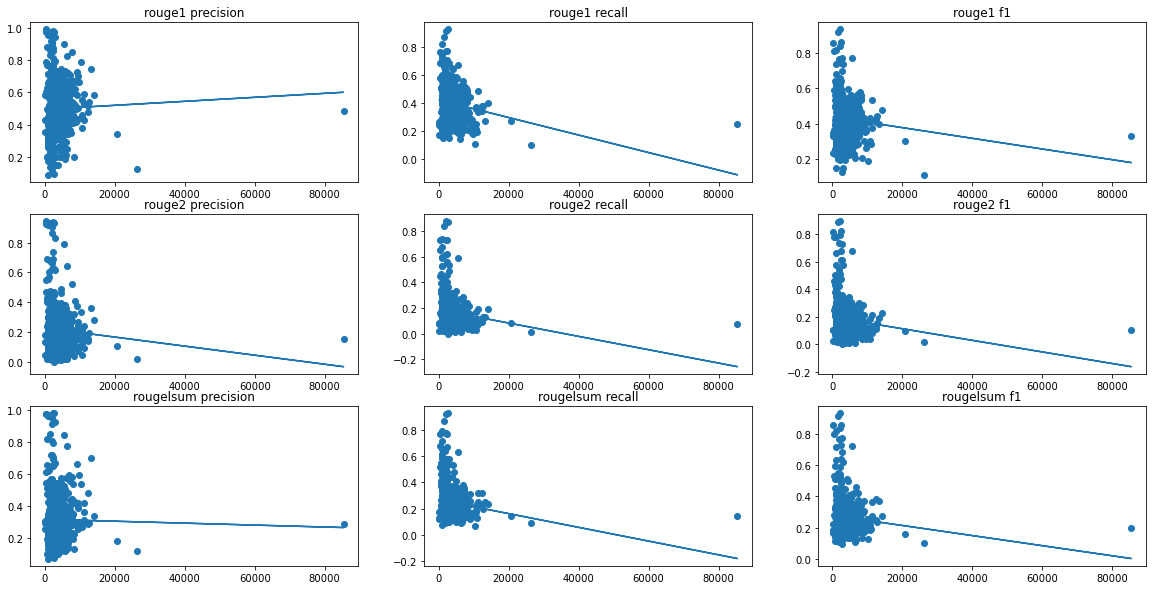

In [19]:
#df = df[df['length'] >= 4096]
fig, axs = plt.subplots(3,3, figsize = (20,10))
axs[0,0].set_title('rouge1 precision')
axs[0,0].scatter(df.length, df.rouge_1_precision)
m1, b1 = np.polyfit(df.length, df.rouge_1_precision, 1)
axs[0,0].plot(df.length, m1*df.length + b1)
#rouge 1
axs[0,1].set_title('rouge1 recall')
axs[0,1].scatter(df.length, df.rouge_1_recall)
m2, b2 = np.polyfit(df.length, df.rouge_1_recall, 1)
axs[0,1].plot(df.length, m2*df.length + b2)

axs[0,2].set_title('rouge1 f1')
axs[0,2].scatter(df.length, df.rouge_1_f1)
m3, b3 = np.polyfit(df.length, df.rouge_1_f1, 1)
axs[0,2].plot(df.length, m3*df.length + b3)


# rouge 2
axs[1,0].set_title('rouge2 precision')
axs[1,0].scatter(df.length, df.rouge_2_precision)
m4, b4 = np.polyfit(df.length, df.rouge_2_precision, 1)
axs[1,0].plot(df.length, m4*df.length + b4)

axs[1,1].set_title('rouge2 recall')
axs[1,1].scatter(df.length, df.rouge_2_recall)
m5, b5 = np.polyfit(df.length, df.rouge_2_recall, 1)
axs[1,1].plot(df.length, m5*df.length + b5)

axs[1,2].set_title('rouge2 f1')
axs[1,2].scatter(df.length, df.rouge_2_f1)
m6, b6 = np.polyfit(df.length, df.rouge_2_f1, 1)
axs[1,2].plot(df.length, m6*df.length + b6)


# rouge lsum
axs[2,0].set_title('rougelsum precision')
axs[2,0].scatter(df.length, df.rouge_lsum_precision)
m7, b7 = np.polyfit(df.length, df.rouge_lsum_precision, 1)
axs[2,0].plot(df.length, m7*df.length + b7)

axs[2,1].set_title('rougelsum recall')
axs[2,1].scatter(df.length, df.rouge_lsum_recall)
m8, b8 = np.polyfit(df.length, df.rouge_lsum_recall, 1)
axs[2,1].plot(df.length, m8*df.length + b8)

axs[2,2].set_title('rougelsum f1')
axs[2,2].scatter(df.length, df.rouge_lsum_f1)
m9, b9 = np.polyfit(df.length, df.rouge_lsum_f1, 1)
axs[2,2].plot(df.length, m9*df.length + b9)

print(f'm1: {m1}, m2: {m2}, m3: {m3}')
print(f'm4: {m4}, m5: {m5}, m6: {m6}')
print(f'm7: {m7}, m8: {m8}, m9: {m9}')
print('\n')
print(f'Rouge 1 f1 Mean: {df.rouge_1_f1.mean()}')
print(f'Rouge 2 f1 Mean: {df.rouge_2_f1.mean()}')
print(f'Rouge lsum f1 Mean: {df.rouge_lsum_f1.mean()}')